# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0,10.0)),
                                       transforms.RandomHorizontalFlip(),
                                       #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 46973131.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 2

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data,**args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# Shape of the train data
print (train_data.data.shape)
# Shape of the test data
print (test_data.data.shape)

# Number of categories in the data
print (len(train_data.classes))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
10


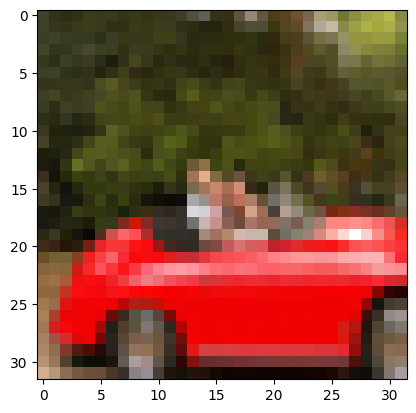

automobile


In [6]:
# Visualizing an image from train data
import matplotlib.pyplot as plt
img = train_data.data[99]
label = train_data.targets[99]

plt.imshow(img)
plt.show()

for key, value in enumerate(train_data.class_to_idx):
  if key == label:
      print (value)

In [7]:
# Calculating mean and std
imgs = torch.stack([img_t for img_t ,_ in train_data],dim=3)
print (imgs.view(3,-1).mean(dim=1))
print (imgs.view(3,-1).std(dim=1))

tensor([-0.1014, -0.1022, -0.0846])
tensor([1.0472, 1.0586, 1.0247])


In [8]:
class Model_Norm(nn.Module):
    def __init__(self,norm_type):
        super(Model_Norm, self).__init__()
        self.norm_type=norm_type
        # Conv Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False)
        if norm_type=='bn':
          self.norm1=nn.BatchNorm2d(16)
        elif norm_type=='ln':
          self.norm1=nn.GroupNorm(num_groups=1,num_channels=10)
        elif norm_type=='gn':
          self.norm1=nn.GroupNorm(num_groups=2,num_channels=10)
        self.dp1=nn.Dropout(p=0.1)

       # Conv Layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False)
        if norm_type=='bn':
          self.norm2=nn.BatchNorm2d(16)
        elif norm_type=='ln':
          self.norm2=nn.GroupNorm(num_groups=1,num_channels=10)
        elif norm_type=='gn':
          self.norm2=nn.GroupNorm(num_groups=4,num_channels=10)
        self.dp2=nn.Dropout(p=0.1)

       # TB Conv Layer1 1*1
        self.conv_tb1 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
       # Max Pool Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

      # Conv Layer 3
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=24, kernel_size=(3, 3), padding=1, bias=False)
        if norm_type=='bn':
          self.norm3=nn.BatchNorm2d(24)
        elif norm_type=='ln':
          self.norm3=nn.GroupNorm(num_groups=1,num_channels=10)
        elif norm_type=='gn':
          self.norm3=nn.GroupNorm(num_groups=4,num_channels=10)
        self.dp3=nn.Dropout(p=0.1)

      # Conv Layer 4
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3), padding=1, bias=False)
        if norm_type=='bn':
          self.norm4=nn.BatchNorm2d(24)
        elif norm_type=='ln':
          self.norm4=nn.GroupNorm(num_groups=1,num_channels=10)
        elif norm_type=='gn':
          self.norm4=nn.GroupNorm(num_groups=4,num_channels=10)
        self.dp4=nn.Dropout(p=0.1)

       # Conv Layer 5
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3), padding=1, bias=False)
        if norm_type=='bn':
          self.norm5=nn.BatchNorm2d(24)
        elif norm_type=='ln':
          self.norm5=nn.GroupNorm(num_groups=1,num_channels=10)
        elif norm_type=='gn':
          self.norm5=nn.GroupNorm(num_groups=4,num_channels=10)
        self.dp5=nn.Dropout(p=0.1)

      # TB Conv Layer2 1*1
        self.conv_tb2 = nn.Conv2d(in_channels=24, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
       # Max Pool Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)

       # Conv Layer 6
        self.conv6 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), padding=1, bias=False)
        if norm_type=='bn':
          self.norm6=nn.BatchNorm2d(32)
        elif norm_type=='ln':
          self.norm6=nn.GroupNorm(num_groups=1,num_channels=10)
        elif norm_type=='gn':
          self.norm6=nn.GroupNorm(num_groups=4,num_channels=10)
        self.dp6=nn.Dropout(p=0.1)

      # Conv Layer 7
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False)
        if norm_type=='bn':
          self.norm7=nn.BatchNorm2d(32)
        elif norm_type=='ln':
          self.norm7=nn.GroupNorm(num_groups=1,num_channels=10)
        elif norm_type=='gn':
          self.norm7=nn.GroupNorm(num_groups=4,num_channels=10)
        self.dp7=nn.Dropout(p=0.1)

       # Conv Layer 8
        self.conv8 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False)
        if norm_type=='bn':
          self.norm8=nn.BatchNorm2d(32)
        elif norm_type=='ln':
          self.norm8=nn.GroupNorm(num_groups=1,num_channels=10)
        elif norm_type=='gn':
          self.norm8=nn.GroupNorm(num_groups=4,num_channels=10)
        self.dp8=nn.Dropout(p=0.1)

       # GAP Layer
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=8))

       # Output Layer
        self.conv9 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)


    def forward(self, x):
        x = self.dp1(self.norm1(F.relu(self.conv1(x))))
        x = x+self.dp2(self.norm2(F.relu(self.conv2(x))))
        x = self.pool1(self.conv_tb1(x))
        x = self.dp3(self.norm3(F.relu(self.conv3(x))))
        x = x+self.dp4(self.norm4(F.relu(self.conv4(x))))
        x = x + self.dp5(self.norm5(F.relu(self.conv5(x))))
        x=  self.pool2(self.conv_tb2(x))
        x = self.dp6(self.norm6(F.relu(self.conv6(x))))
        x = x+self.dp7(self.norm7(F.relu(self.conv7(x))))
        x = x+self.dp8(self.norm8(F.relu(self.conv8(x))))
        x = self.gap(x)
        x = self.conv9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
# Model Summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_Norm(norm_type='bn').to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
           Dropout-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
           Dropout-6           [-1, 16, 32, 32]               0
            Conv2d-7            [-1, 8, 32, 32]             128
         MaxPool2d-8            [-1, 8, 16, 16]               0
            Conv2d-9           [-1, 24, 16, 16]           1,728
      BatchNorm2d-10           [-1, 24, 16, 16]              48
          Dropout-11           [-1, 24, 16, 16]               0
           Conv2d-12           [-1, 24, 16, 16]           5,184
      BatchNorm2d-13           [-1, 24, 16, 16]              48
          Dropout-14           [-1

In [ ]:
# Training And Testing

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss


In [11]:
from torch.optim.lr_scheduler import StepLR
model =  Model_Norm(norm_type='bn').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4184179306030273 Batch_id=390 Accuracy=40.05: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s]



Test set: Average loss: 1.4039, Accuracy: 4843/10000 (48.43%)

EPOCH: 1


Loss=1.328134536743164 Batch_id=390 Accuracy=52.98: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s]



Test set: Average loss: 1.1876, Accuracy: 5669/10000 (56.69%)

EPOCH: 2


Loss=1.1738730669021606 Batch_id=390 Accuracy=57.67: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s]



Test set: Average loss: 1.1321, Accuracy: 5923/10000 (59.23%)

EPOCH: 3


Loss=1.0854395627975464 Batch_id=390 Accuracy=60.43: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s]



Test set: Average loss: 1.0432, Accuracy: 6268/10000 (62.68%)

EPOCH: 4


Loss=1.1626036167144775 Batch_id=390 Accuracy=62.26: 100%|██████████| 391/391 [00:50<00:00,  7.79it/s]



Test set: Average loss: 1.0094, Accuracy: 6418/10000 (64.18%)

EPOCH: 5


Loss=1.0573418140411377 Batch_id=390 Accuracy=63.88: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]



Test set: Average loss: 1.0033, Accuracy: 6454/10000 (64.54%)

EPOCH: 6


Loss=0.7768601179122925 Batch_id=390 Accuracy=66.28: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]



Test set: Average loss: 0.9054, Accuracy: 6813/10000 (68.13%)

EPOCH: 7


Loss=0.9752264022827148 Batch_id=390 Accuracy=66.98: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]



Test set: Average loss: 0.8959, Accuracy: 6838/10000 (68.38%)

EPOCH: 8


Loss=0.7978191375732422 Batch_id=390 Accuracy=67.16: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]



Test set: Average loss: 0.8892, Accuracy: 6900/10000 (69.00%)

EPOCH: 9


Loss=1.0398063659667969 Batch_id=390 Accuracy=67.37: 100%|██████████| 391/391 [00:51<00:00,  7.57it/s]



Test set: Average loss: 0.8860, Accuracy: 6883/10000 (68.83%)

EPOCH: 10


Loss=0.9116336703300476 Batch_id=390 Accuracy=67.73: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s]



Test set: Average loss: 0.8756, Accuracy: 6937/10000 (69.37%)

EPOCH: 11


Loss=0.7318438291549683 Batch_id=390 Accuracy=67.82: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s]



Test set: Average loss: 0.8799, Accuracy: 6930/10000 (69.30%)

EPOCH: 12


Loss=0.6591247916221619 Batch_id=390 Accuracy=68.16: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]



Test set: Average loss: 0.8608, Accuracy: 6983/10000 (69.83%)

EPOCH: 13


Loss=0.7545410990715027 Batch_id=390 Accuracy=68.28: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]



Test set: Average loss: 0.8608, Accuracy: 6989/10000 (69.89%)

EPOCH: 14


Loss=0.8919620513916016 Batch_id=390 Accuracy=68.25: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]



Test set: Average loss: 0.8638, Accuracy: 6983/10000 (69.83%)

EPOCH: 15


Loss=0.7538849115371704 Batch_id=390 Accuracy=68.16: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]



Test set: Average loss: 0.8615, Accuracy: 6996/10000 (69.96%)

EPOCH: 16


Loss=0.9706606864929199 Batch_id=390 Accuracy=68.09: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]



Test set: Average loss: 0.8629, Accuracy: 6983/10000 (69.83%)

EPOCH: 17


Loss=0.9162384867668152 Batch_id=390 Accuracy=67.97: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s]



Test set: Average loss: 0.8625, Accuracy: 6984/10000 (69.84%)

EPOCH: 18


Loss=1.0478864908218384 Batch_id=390 Accuracy=68.16: 100%|██████████| 391/391 [00:53<00:00,  7.24it/s]



Test set: Average loss: 0.8683, Accuracy: 6971/10000 (69.71%)

EPOCH: 19


Loss=0.8491148948669434 Batch_id=390 Accuracy=68.18: 100%|██████████| 391/391 [00:52<00:00,  7.42it/s]



Test set: Average loss: 0.8638, Accuracy: 6978/10000 (69.78%)



In [ ]:

# Wrong predictions
cnt=0
import random
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
img_lst=[]
cat_lst=[]
x_lst=[]
for i in range(0,127):
  x = random.randint(0,127)

  if pred[x].item()!=target[x].item():
    img=data[x].cpu().numpy().T
    img_lst.append(img)
    cat=[value for key,value in enumerate(train_data.class_to_idx) if key==target[x].item()][0]
    cat_lst.append(cat)
    x_lst.append(x)
    cnt+=1
  if cnt>9:
    break

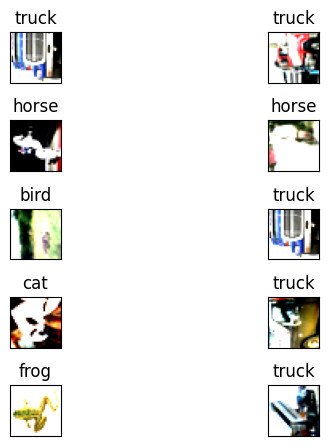

In [ ]:
for i in range(10):
  plt.subplot(5,2,i+1)
  plt.tight_layout()
  plt.imshow(img_lst[i])
  plt.title(cat_lst[i])
  plt.xticks([])
  plt.yticks([])